In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import kurtosis

from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor, AdaBoostRegressor

In [2]:
# Define the directory of the train data
from pathlib import Path
train_data_dir = Path('train')

## a. Load the first sample (0.txt) and visualize the acceleration in the x direction of bearing 4. Compare this visualization to 3 other samples from different degradation stages.

In [6]:
# Inspect and load the sample based on the file name.
def data_(file_name):
    sample_file = os.path.join(train_data_dir, file_name)
    bearing_data = pd.read_csv(sample_file, delimiter=';')    

    return bearing_data

# To simplify the visualization, we made a function.
def viz_acceleration_bearing_data(csv_data, y_column):
    bearing_data = data_(csv_data)
    y0 = bearing_data[y_column]
    _, Pxx = welch(bearing_data[y_column])
    spectral_flatness = np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)
    ptp = np.ptp(bearing_data[y_column])

    plt.figure(figsize=(10, 8))
    plt.xlabel('Acceleration (m/s^2)')
    plt.ylabel('Frequency')
    plt.title(f'Acceleration in x-direction of Bearing 4 (Source = {csv_data})')
    plt.gcf().text(0.85, 0.17, f'Spectral Flatness: {spectral_flatness:.4f}', fontsize=10, horizontalalignment='right')
    plt.gcf().text(0.85, 0.20, f'PTP: {ptp:.4f}', fontsize=10, horizontalalignment='right')

    plt.hist(y0)

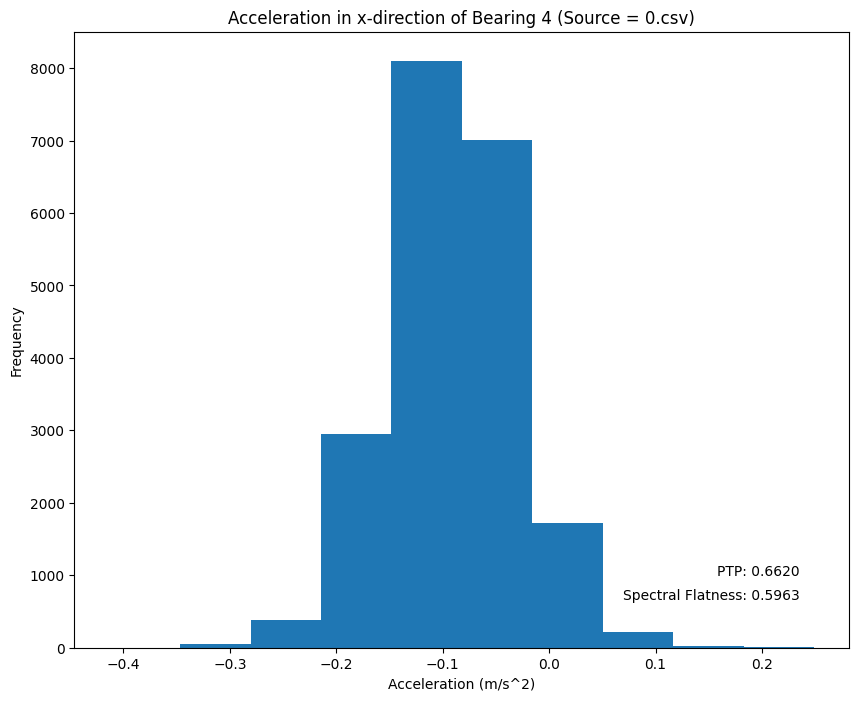

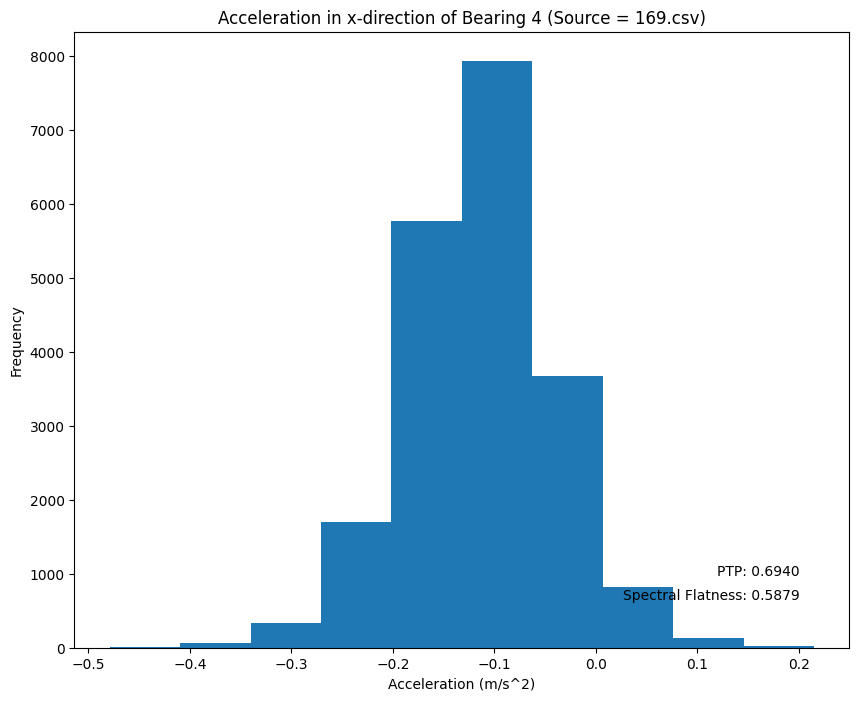

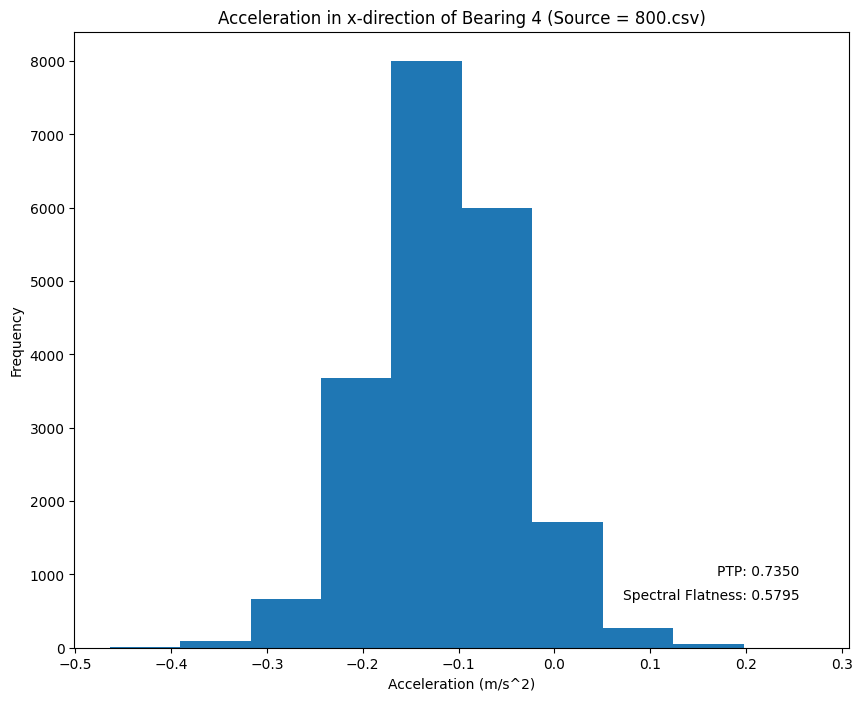

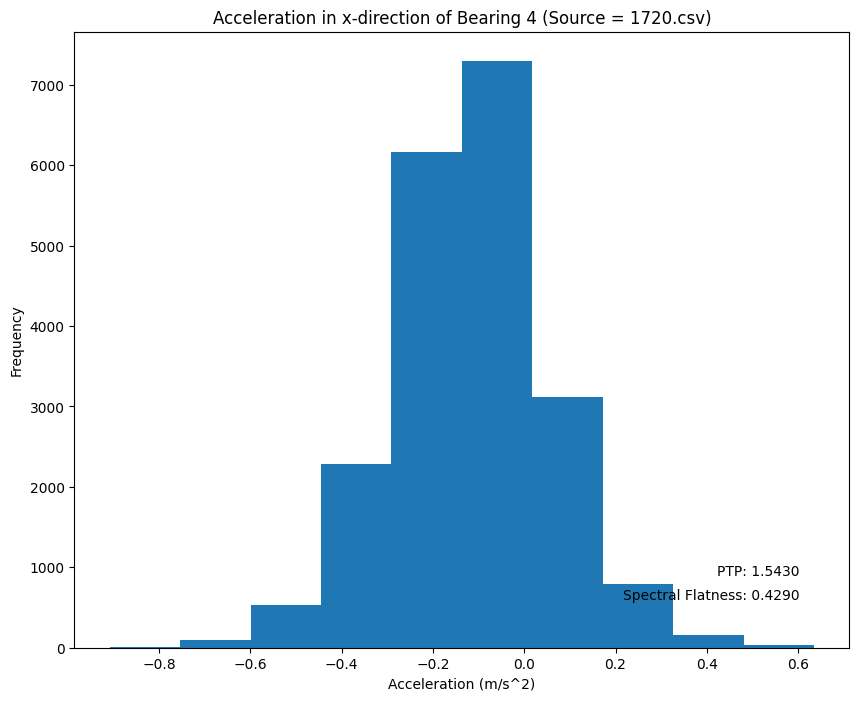

In [7]:
# Load the first sample (0.txt) and visualize the acceleration in the x direction of bearing 4. 
viz_acceleration_bearing_data('0.csv', 'b4x')

# Compare this visualization to 3 other samples from different degradation stages.
viz_acceleration_bearing_data('169.csv', 'b4x') # Stage 1
plt.show()
viz_acceleration_bearing_data('800.csv', 'b4x') #  Stage 2
plt.show()
viz_acceleration_bearing_data('1720.csv', 'b4x') # Stage 4
plt.show()


## b. Make a function that, given an index, loads the corresponding sample and returns mean, standard deviation, and root mean squared of both x and y acceleration. 

In [4]:
def features_acceleration_data(sample, index=-1):
    # sample = data_(file_name)

    # Make a function that, given an index, loads the corresponding sample and returns mean, standard deviation,
    # and root mean squared of both x and y acceleration.
    if index == -1:
        pass

    elif index or index == 0:
        print(f"Corresponding Sample: ({sample.loc[index, 'b4x']},{sample.loc[index, 'b4y']})")
    
        # Calculates the mean, standard deviation, and
        # root mean squared of both x and y acceleration
        # sample_x = sample.b4x.iloc[index] 
        # sample_y = sample.b4y.iloc[index] 

    mean_x = sample.b4x.mean()
    mean_y = sample.b4y.mean()
    std_x = sample.b4x.std()
    std_y = sample.b4y.std()
    rms_x = np.sqrt(np.mean(sample.b4x**2))
    rms_y = np.sqrt(np.mean(sample.b4x**2))
    
    # First feature to add: Spectral Flatness
    _, Pxx_x = welch(sample.b4x)
    spectral_flatness_x = np.exp(np.mean(np.log(Pxx_x))) / np.mean(Pxx_x)
    _, Pxy_y = welch(sample.b4y)
    spectral_flatness_y = np.exp(np.mean(np.log(Pxy_y))) / np.mean(Pxy_y)

    # Second feature to add: Kurtosis
    kurtosis_x = kurtosis(sample.b4x)
    kurtosis_y = kurtosis(sample.b4y)

    # 
    peak_to_peak_x = np.ptp(sample.b4x)
    peak_to_peak_y = np.ptp(sample.b4y)

    features = {
        'mean_x': mean_x,
        'mean_y': mean_y,
        'std_x': std_x,
        'std_y': std_y,
        'rms_x': rms_x,
        'rms_y': rms_y,
        'spectral_flatness_x': spectral_flatness_x,
        'spectral_flatness_y': spectral_flatness_y,
        'kurtosis_x': kurtosis_x,
        'kurtosis_y': kurtosis_y,
        'peak_to_peak_x': peak_to_peak_x,
        'peak_to_peak_y': peak_to_peak_y
    }
    return features
    
features_acceleration_data(data_('0.csv'))

{'mean_x': -0.09096875,
 'mean_y': -0.094235205078125,
 'std_x': 0.06008602164049359,
 'std_y': 0.0663816272503547,
 'rms_x': 0.10902048975995292,
 'rms_y': 0.10902048975995292,
 'spectral_flatness_x': 0.5962608450036389,
 'spectral_flatness_y': 0.8044983999172042,
 'kurtosis_x': 0.7902499085116994,
 'kurtosis_y': 1.8079901941922039,
 'peak_to_peak_x': 0.6619999999999999,
 'peak_to_peak_y': 0.845}

Why Spectral Flatness and Kurtosis? (Visualization Check)

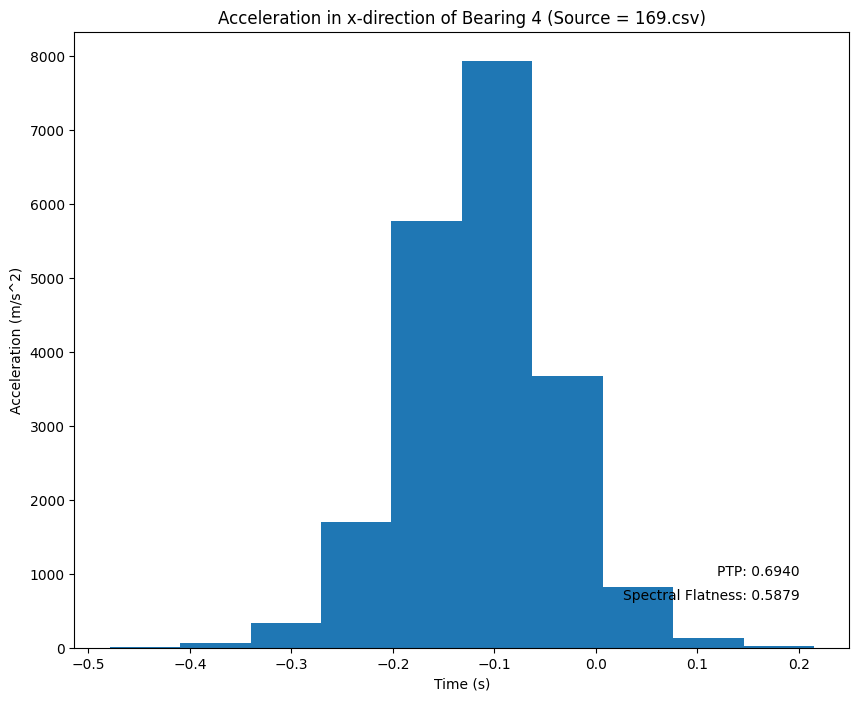

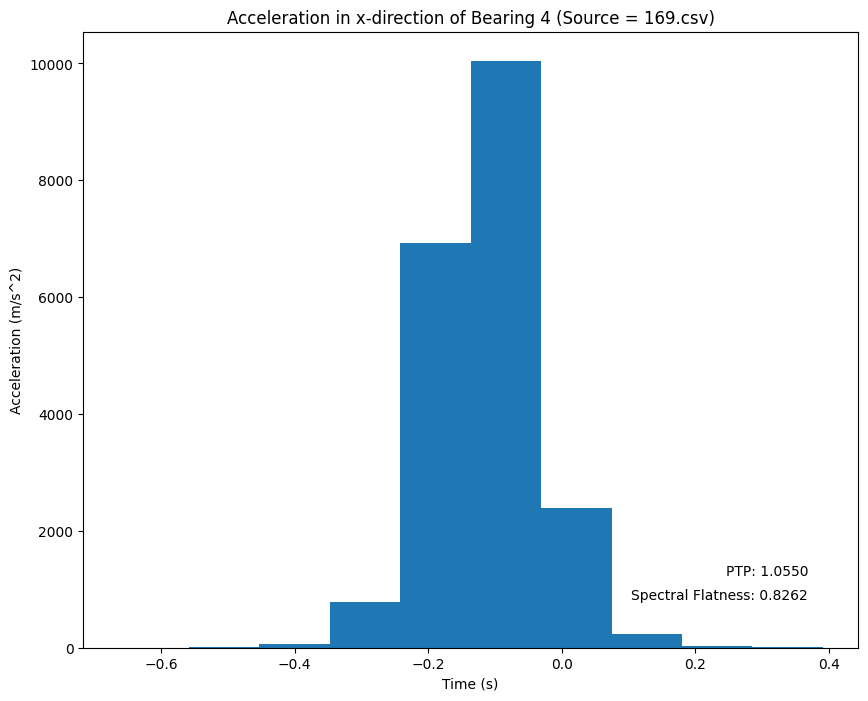

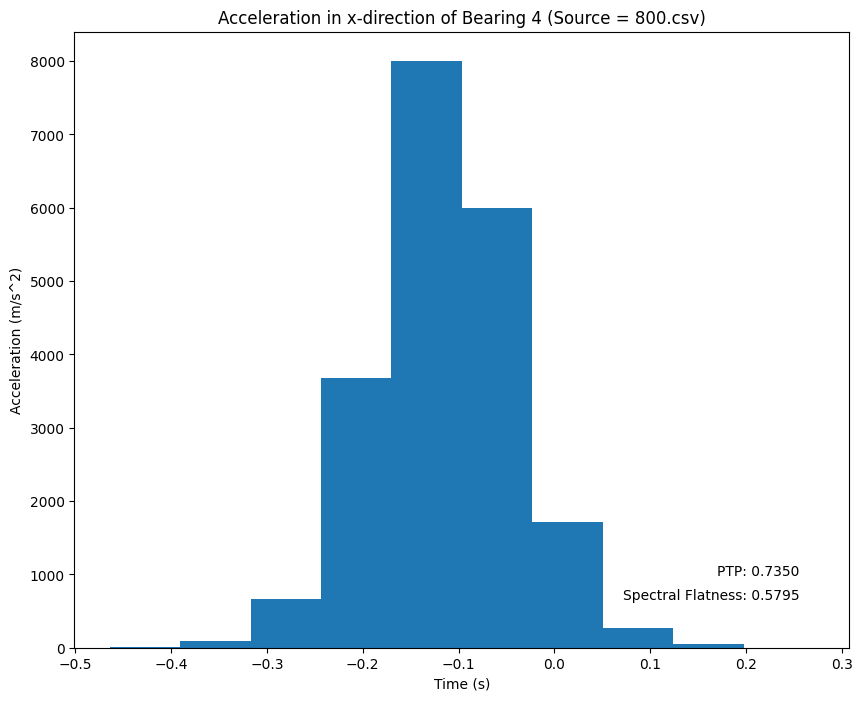

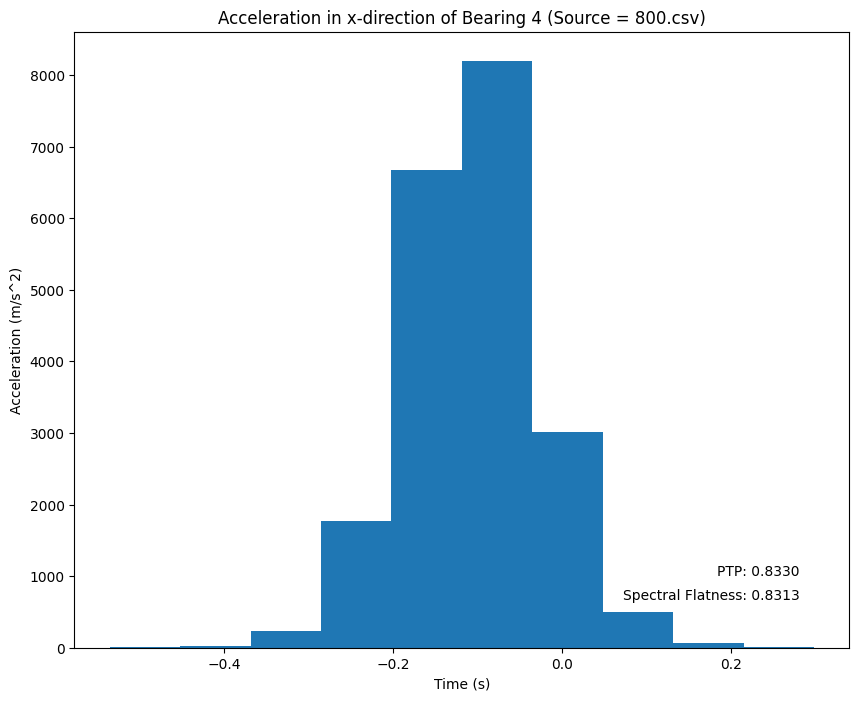

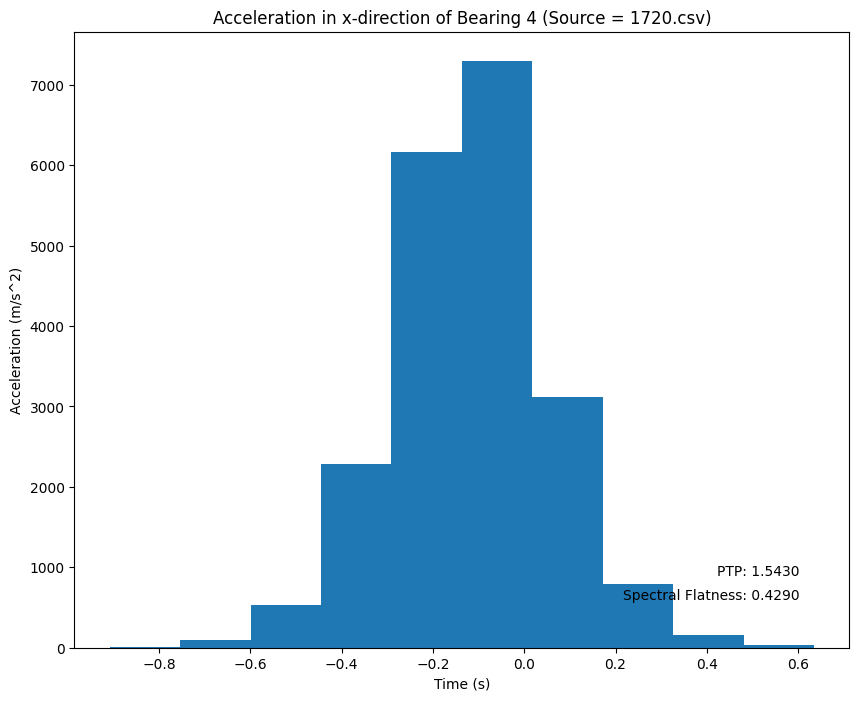

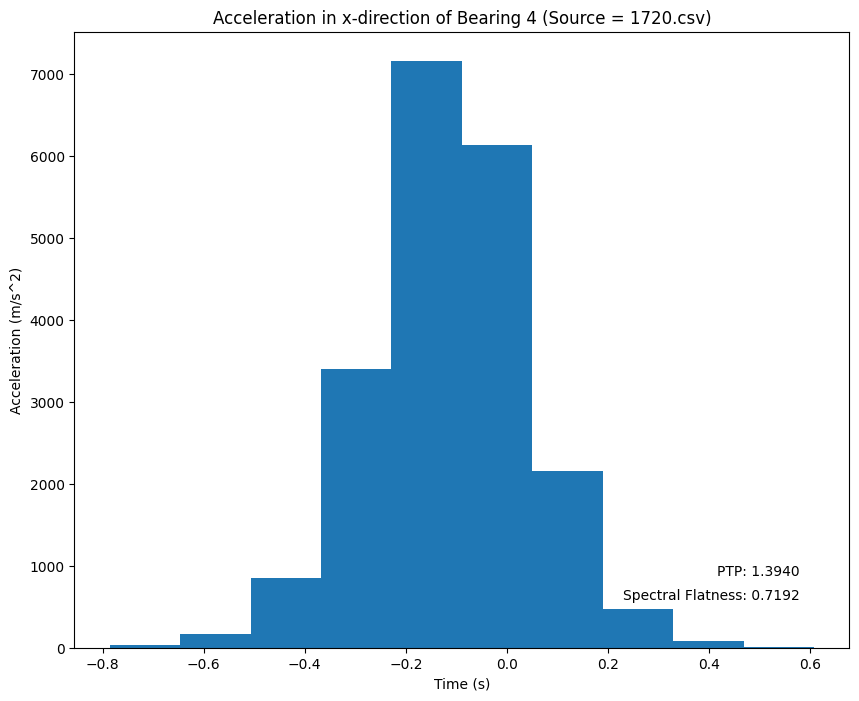

## c. Apply the function from b. to the entire dataset and store your results in a dataframe. Perform some explanatory data analysis to get some insight on which classification models might be suitable for predicting the degradation stage.

In [43]:
# List to store feature data
feature_list = []

def extract_numeric_part(file_name):
    """Extract numeric part from file name assuming it is an integer."""
    return int(''.join(filter(str.isdigit, file_name)))

try:
    # Get list of files
    file_names = os.listdir(train_data_dir)
    int_file_names = []
    for file_name in file_names:
        int_file_names.append(extract_numeric_part(file_name))

    # Sort files by numeric part
    sorted_file_names = sorted(int_file_names)

    # Calculate features
    file_names = [f"{file_name}.csv" for file_name in sorted_file_names]

    for file_name in file_names:
        features = features_acceleration_data(data_(file_name))
        
        if features:
            # Add the file name to the features
            features['file'] = file_name
            
            # Append the features to the list
            feature_list.append(features)
except AttributeError:
    print(file_name)

except ValueError:
    print(file_name)
    
# Dataframe of the appended features
feature_df = pd.DataFrame(feature_list)

In [105]:
feature_df[feature_df.b4_state == 3]

,mean_x,mean_y,std_x,std_y,rms_x,rms_y,spectral_flatness_x,spectral_flatness_y,kurtosis_x,kurtosis_y,peak_to_peak_x,peak_to_peak_y,b4_state
1149,-0.115425,-0.114329,0.085701,0.088361,0.143760,0.143760,0.532753,0.792660,1.313050,1.357987,1.255,1.062,3
1150,-0.112823,-0.113675,0.089209,0.088721,0.143829,0.143829,0.516308,0.780113,4.434425,1.359104,1.921,1.243,3
1151,-0.114480,-0.113586,0.086041,0.087846,0.143207,0.143207,0.526415,0.786682,1.962290,1.103378,1.575,1.211,3
1152,-0.114800,-0.114375,0.088503,0.090864,0.144954,0.144954,0.536429,0.779148,3.062344,2.120883,1.458,1.494,3
1153,-0.114317,-0.114119,0.085864,0.089242,0.142971,0.142971,0.533106,0.776696,3.113403,1.409946,1.670,1.054,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,-0.114045,-0.115513,0.137136,0.140289,0.178358,0.178358,0.558092,0.800871,1.579506,2.237030,1.796,1.875,3
1479,-0.115426,-0.115155,0.133912,0.139322,0.176790,0.176790,0.573844,0.800495,1.946283,2.776708,1.706,2.376,3
1480,-0.113907,-0.115070,0.135480,0.138515,0.176999,0.176999,0.554601,0.803753,1.696711,2.575327,1.614,2.083,3
1481,-0.114351,-0.114524,0.131983,0.132694,0.174627,0.174627,0.557100,0.811093,1.907335,2.451406,1.555,2.033,3


Text(0, 0.5, 'ptp x')

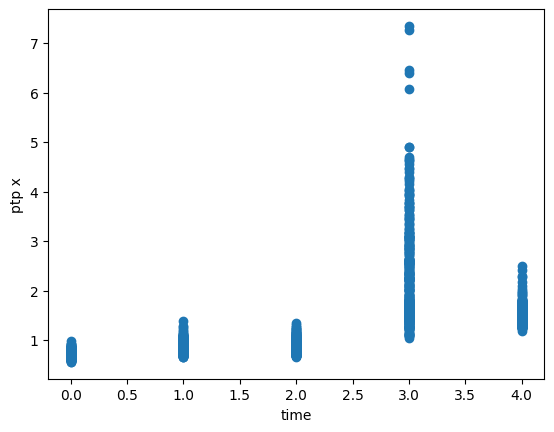

In [124]:
bearing_data = pd.read_csv('bearing_conditions.csv')
feature_df['b4_state'] = bearing_data['b4_state']
plt.scatter(feature_df.b4_state, feature_df.peak_to_peak_x)
plt.xlabel('time')
plt.ylabel('ptp x')

In [147]:
# Before performing exploratory data analysis,
# we will firstly split the data
X = feature_df[['peak_to_peak_x', 'peak_to_peak_y', 'spectral_flatness_x', 'spectral_flatness_y', 'mean_x', 'mean_y', 'std_x', 'std_y']]
y = feature_df['b4_state']

In [155]:
# feature_df = feature_df.drop('file', axis=1)

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_df)

# Apply PCA

grid_search = GridSearchCV(PCA(), param_grid={'n_components': np.arange(1, X.shape[1]+1)}, cv = 3, n_jobs = -1,
    verbose = 3, scoring = 'neg_mean_absolute_error')

grid_search.fit(X_train, y_train)

features_reduced = pca.fit_transform(features_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_reduced, feature_df['b4_state'], test_size=0.2, random_state=42)

In [156]:
rf = RandomForestClassifier(max_depth=8, n_estimators=50, random_state=42)
# gcv_rf = GridSearchCV(rf, param_grid={
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [None, 2, 4, 6, 8, 10],
#     'min_samples_split': [2, 10, 20, 40]},
#     cv = 3, n_jobs = -1,
#     verbose=3, scoring = 'neg_mean_absolute_error')

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
# best_rf = rf.best_estimator_

# print('Best hyperparameter(s):', rf.best_params_)
# print('Best score:', rf.best_score_)
# print('Best model:', best_rf)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        29
           1       0.96      0.92      0.94       143
           2       0.88      0.92      0.90        66
           3       0.95      0.98      0.97        58
           4       0.98      0.94      0.96        49

    accuracy                           0.94       345
   macro avg       0.93      0.95      0.94       345
weighted avg       0.94      0.94      0.94       345

Accuracy: 0.936231884057971


## d. We have used the standard deviation and the rms. However, these features are highly correlated. Explain why these features are highly correlated (either in words or mathematically).

In [ ]:
# Firstly we can examine what the formula is for both features:
# RMS = sqrt( (1/N) * sum(x_i^2) )
# Stdev = sqrt( (1/N) * sum((x_i - mean)^2) )

# While they both aim to calculate the variability of the data, they do it slightly differently
# since Stdev considered the data's mean and RMS does not.

# However, these features will become increasingly similar as the mean approaches zero
# Where the mean is approximately zero, (x_i - mean) in Stdev becomes x_i -- just like in RMS.

# And small mean values are the case in this data, as we can see from the results of the features function in b.
# Therefore, it makes sense why these values are highly correlated.

## e. (1) Make one or several machine learning models to predict the degradation stage based on the features calculated in the previous exercises. Explain why you chose these models and their parameters.

In [150]:
rf = RandomForestClassifier(random_state=42)
gcv_rf = GridSearchCV(rf, param_grid={
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 10, 20, 40]},
    cv = 3, n_jobs = -1,
    verbose=3, scoring = 'neg_mean_absolute_error')

gcv_rf.fit(X_train, y_train)
y_pred = RandomForestClassifier(n_estimators=10, random_state=42).fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

best_rf = gcv_rf.best_estimator_

# print('Best hyperparameter(s):', rf.best_params_)
# print('Best score:', rf.best_score_)
print('Best model:', best_rf)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       1.00      0.99      1.00       143
           2       1.00      1.00      1.00        66
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        49

    accuracy                           1.00       345
   macro avg       0.99      1.00      1.00       345
weighted avg       1.00      1.00      1.00       345

Accuracy: 0.9971014492753624
Best model: RandomForestClassifier(random_state=42)


In [159]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with PCA and a classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define parameter grid for PCA
param_grid = {
    'pca__n_components': np.arange(1, X.shape[1]+1),
    'clf__n_estimators': [10, 50, 100, 200],
    'clf__max_depth': [None, 2, 4, 6, 8, 10],
    'clf__min_samples_split': [2, 10, 20, 40]}


# Grid search cross-validation
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv = 3, n_jobs = -1,
    verbose=3, scoring = 'neg_mean_absolute_error')

grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", test_accuracy)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits
